In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
%matplotlib inline

Pro simulace a zkoušení různých schémat by se nám hodil nějaký "obal" pro naše schémata, který by se zároveň mohl postarat o uchování dat. Zárověň by nám mohl umožnit relativně snadné napojení na interaktivní widget kde bychom výsledky simulace mohli pohodlně sledovat. K takovému účelu nám velice dobře může posloužit námi definovaná třída. Jednotlivé funkce v této třídě budou mít pohodlně přístup k datům a při vytvíření instance můžeme vložit zvenčí definované schéma (případně ho později změnit).

Začneme tedy tím, že si nejprve definujeme funkci našeho (zatím testovacího) schématu.

In [2]:
'''
Up-wind
'''
def upwind(data, dx, dt, v):
    u = np.copy(data[:,1])
    data[1:-2,1] = u[1:-2]-(v*dt/dx) * (u[1:-2]-u[:-3])
    return data

Připravíme si také testovací profil. V tomto případě poměrně jednoduchý.

In [3]:
def profile(x):
    tmp = np.ones_like(x) + 1.0
    tmp[x<0.5] = 1.0
    tmp[x>1.0] = 1.0
    return tmp

Nyní se můžeme pustit do implementace naší vysněné třídy. Pohledem na její kód zjistíme, že naše třída má několik důležitých funkcí. První z nich je funkce __init__ , která je zavolána vždy jako první při vytvoření nové instance třídy. Tato fukce očekává několik argumentů ... scheme - což je přímo funkce schématu (např. ta námi výše definovaná), data - počátační stav profilu, c - Courantovo-Friedrichsovo-Lewyho číslo ovlivňující přesnost řesení (nepovinný argument s deafaultní hodnotou c=0.4).

Další velice důležitou funkcí je get_dt, která na základě zadané rychlosti určí paramert dt tak, aby řešení bylo stabilní. 

Dále následují funkce solve a plot, jejichž význam je už z názvů zřejmý. Solve očekává jako argumenty t_end udávající konečný čas simulace a v určující rychlost. Zavoláním funkce solve se provede celý vypočet až do času t_end a všechny mezivýsledky v časových krocích jsou uloženy do "kontejneru" aby přístup k datům z interaktivního plotu nevyžadoval pokaždé přepočítávat od začátku.

Funkce plot už pak pouze vykresluje graf v zadaném čase t.

In [4]:
class Solver:
    def __init__(self, scheme, data, c=0.4):
        self.set_scheme(scheme)
        self.data = np.copy(data)
        self.container = [np.copy(data)]
        self.c = c
        self.dx = abs(data[1,0]-data[0,0])
    
    def set_scheme(self, scheme):
        self.scheme = scheme
    
    def get_dt(self, v):
        return self.c*self.dx/v
    
    def solve(self, t_end, v):
        dt = self.get_dt(v)
        self.t_end = t_end
        t = 0.0
        while t <= t_end:
            self.data = self.scheme(self.data, self.dx, dt, v)
            self.container.append(np.copy(self.data))
            t += dt
    
    def plot(self, t):
        i = int((t/self.t_end)*len(self.container))
        plt.xlim((0, 2))
        plt.ylim((0,3))
        plt.plot(self.container[i][:,0], self.container[i][:,1])

Tak si naší skromně vypadající třídu vyzkoušíme s interativním plotem :)

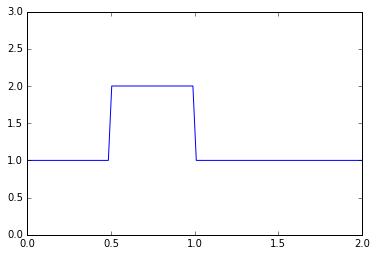

In [7]:
n = 100
x = np.linspace(0.0, 2.0, n)
data = np.column_stack((x, profile(x)))
sol = Solver(upwind, data)

t_end, v = 2.5, 0.5
sol.solve(t_end, v)

interact(sol.plot,
         t=FloatSlider(min=0.0, max=t_end, step=sol.get_dt(v)))

Použití tohoto přístupu k výpočtu nám dáva poměrně široké možnosti zkoušení, srovnávaní a ladění různých schémat bez nutnosti mnohokrát vypisovat stejný nebo velmi podobný kód. O všechny důležíté aspekty výpočtu se postará naše třída Solver a my se můžeme soustředit na hrátky se schématy. Schopnosti takové třídy je samozřejmě možné dále rozšiřovat např. o možnost výpisu vysledků do souboru apod.